# FIFA 19 Machine Learning

## Problem Definition
Build a prediction model to predict a player's overall rating.

In [1]:
# import libraries
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn :: utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# sklearn :: models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# sklearn :: evaluation metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

sns.set_style('whitegrid')

## Load Data

In [2]:
df = pd.read_csv('Data/fifa19data_clean.csv')
print(df.columns)

Index(['Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club', 'Value',
       'Wage', 'Special', 'Preferred Foot', 'International Reputation',
       'Weak Foot', 'Skill Moves', 'Work Rate', 'Position', 'Height', 'Weight',
       'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM',
       'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB',
       'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes'],
      dtype='object')


## Feature Engineering

Split the 'Work Rate' feature into 'Attack Work Rate' and 'Defensive Work Rate' and one-hot encode the following categorical features of the dataset:
    - Preferred Foot
    - Attack and Defensive Work Rate
    - Position

In [3]:
# split Work Rate into 2 separate features
df['Attack Work Rate'] = df.apply(lambda row: row['Work Rate'].split("/ ")[0], axis=1)
df['Defensive Work Rate'] = df.apply(lambda row: row['Work Rate'].split("/ ")[1], axis=1)

In [4]:
# group similar positions together
forward = ['RS', 'LS', 'RF', 'LF', 'CF', 'ST']

attack_mid = ['RAM', 'LAM', 'CAM']
wings = ['RM', 'RW', 'LM', 'LW']

central_mid = ['CM', 'LCM', 'RCM']
defensive_mid = ['CDM', 'LDM', 'RDM']

fullback = ['RB', 'RWB', 'LB', 'LWB']
cb_def = ['CB', 'LCB', 'RCB']

gk = ['GK']

In [5]:
# group similar positions together and make new feature 'Position Category'
def groupPosition(position):
    forward = ['RS', 'LS', 'RF', 'LF', 'CF', 'ST']
    attack_mid = ['RAM', 'LAM', 'CAM']
    wings = ['RM', 'RW', 'LM', 'LW']
    central_mid = ['CM', 'LCM', 'RCM']
    defensive_mid = ['CDM', 'LDM', 'RDM']
    fullback = ['RB', 'RWB', 'LB', 'LWB']
    cb_def = ['CB', 'LCB', 'RCB']

    if position == 'GK':
        return 'GK'
    elif position in forward:
        return 'FW'
    elif position in attack_mid:
        return 'AM'
    elif position in wings:
        return 'W'
    elif position in central_mid:
        return 'CM'
    elif position in defensive_mid:
        return 'DM'
    elif position in fullback:
        return 'FB'
    elif position in cb_def:
        return 'CB'

df['Position Category'] = df['Position'].apply(groupPosition)

In [6]:
# one-hot encode categorical features
categorical = ['Preferred Foot', 'Attack Work Rate', 'Defensive Work Rate', 'Position Category']
dummy_prefix = ['Foot', 'AWR', 'DWR', 'Pos']

for i in range(0, len(categorical)):
    df = pd.concat([df, pd.get_dummies(df[categorical[i]], prefix=dummy_prefix[i])], axis=1)

In [7]:
# make a new df with normalized numerical features
df_normalized = df.copy()

cat_cols = ['Name', 'Nationality', 'Club', 'Preferred Foot', 'Work Rate', 'Attack Work Rate', 'Defensive Work Rate', 'Position', 'Position Category']

num_cols = list(set(list(df.columns)) - set(cat_cols))

for col in num_cols:
    df_normalized[col] = StandardScaler().fit_transform(df_normalized[col].values.reshape(-1, 1))

G:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
G:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
G:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
G:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
G:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConv

In [8]:
# create dataframes for each group of positions
df_gk = df[df['Position'] == 'GK']
df_gk_norm = df_normalized[df_normalized['Position'] == 'GK']

df_fw = pd.DataFrame()
df_am = pd.DataFrame()
df_wings = pd.DataFrame()
df_cm = pd.DataFrame()
df_dm = pd.DataFrame()
df_fullback = pd.DataFrame()
df_cb = pd.DataFrame()

df_fw_norm = pd.DataFrame()
df_am_norm = pd.DataFrame()
df_wings_norm = pd.DataFrame()
df_cm_norm = pd.DataFrame()
df_dm_norm = pd.DataFrame()
df_fullback_norm = pd.DataFrame()
df_cb_norm = pd.DataFrame()

def aggregatePositions(df_pos, df_data, positions):
    for pos in positions:
        df_pos = pd.concat([df_pos, df_data[df_data['Position'] == pos]])
    return df_pos

df_fw = aggregatePositions(df_fw, df, forward)
df_am = aggregatePositions(df_am, df, attack_mid)
df_wings = aggregatePositions(df_wings, df, wings)
df_cm = aggregatePositions(df_cm, df, central_mid)
df_dm = aggregatePositions(df_dm, df, defensive_mid)
df_fullback = aggregatePositions(df_fullback, df, fullback)
df_cb = aggregatePositions(df_cb, df, cb_def)

df_fw_norm = aggregatePositions(df_fw_norm, df_normalized, forward)
df_am_norm = aggregatePositions(df_am_norm, df_normalized, attack_mid)
df_wings_norm = aggregatePositions(df_wings_norm, df_normalized, wings)
df_cm_norm = aggregatePositions(df_cm_norm, df_normalized, central_mid)
df_dm_norm = aggregatePositions(df_dm_norm, df_normalized, defensive_mid)
df_fullback_norm = aggregatePositions(df_fullback_norm, df_normalized, fullback)
df_cb_norm = aggregatePositions(df_cb_norm, df_normalized, cb_def)

## Model Training and Evaluation

The hypothesis is that feature importance will differ by positions and thus, positions should be stratified by similarity. Hence, a model is required for each group of positions.

In [9]:
# functions to run models

def model_training(model_name, model, X_train, y_train):
    model.fit(X_train, y_train)
    return model
    
def model_prediction(model, X_test):
    y_pred = model.predict(X_test)
    return y_pred

def model_evaluation(model_name, y_test, y_pred):
    print(model_name)
    print('MAE', mean_absolute_error(y_test, y_pred))
    print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
    #print('r', pearsonr(y_test, y_pred))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot(range(0,10), range(0,10), '--r', alpha=0.3, label='Line1')
    plt.title(model_name)
    plt.xlabel('True Value')
    plt.ylabel('Predicted Value')
    plt.show()
    print('')

def run_experiment(model_name, model, X_train, y_train, X_test, y_test):
    train_model = model_training(model_name, model, X_train, y_train)
    predictions = model_prediction(train_model, X_test)
    model_evaluation(model_name, y_test, predictions)
    return train_model, predictions

In [10]:
X_columns = list(set(num_cols) - set(['Overall']))

y_column = ['Overall']

### All players considered - no position grouping

Linear Regression - All Players
MAE 1.3358646490038644
RMSE 1.6903452402170613


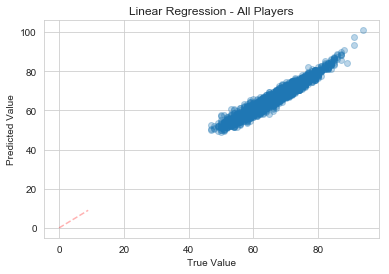


Random Forest Regression - All Players
MAE 0.24097191629955966
RMSE 0.45499857796166415


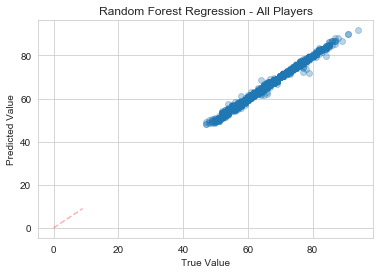


Decision Tree Regression - All Players
MAE 0.2767070484581498
RMSE 0.7104087673586863


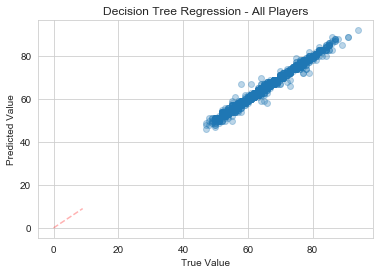


KNN Regression - All Players
MAE 0.21595033098522265
RMSE 0.27556146594481223


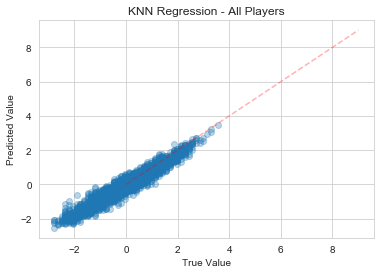

In [11]:
threshold = 0.8

X_all = df[X_columns]
y_all = df[y_column]

X_all_norm = df_normalized[X_columns]
y_all_norm = df_normalized[y_column]

X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y_all, test_size=1.0-threshold, shuffle=True)
X_allnorm_train, X_allnorm_test, y_allnorm_train, y_allnorm_test = train_test_split(X_all_norm, y_all_norm, test_size=1.0-threshold, shuffle=True)

all_Lin_model, all_Lin_pred = run_experiment('Linear Regression - All Players', LinearRegression(), X_all_train, y_all_train, X_all_test, y_all_test)
all_RF_model, all_RF_pred = run_experiment('Random Forest Regression - All Players', RandomForestRegressor(100), X_all_train, y_all_train.values.ravel(), X_all_test, y_all_test)

# all_LinNorm_model, all_LinNorm_pred = run_experiment('Linear Regression Normalized - All Players', LinearRegression(), X_allnorm_train, y_allnorm_train, X_allnorm_test, y_allnorm_test)
all_DT_model, all_DT_pred = run_experiment('Decision Tree Regression - All Players', DecisionTreeRegressor(), X_all_train, y_all_train, X_all_test, y_all_test)
all_KNN_model, all_KNN_pred = run_experiment('KNN Regression - All Players', KNeighborsRegressor(), X_allnorm_train, y_allnorm_train, X_allnorm_test, y_allnorm_test)

### Specific Position Groupings

In [12]:
threshold = 0.8

X_fw = df_fw[X_columns]
X_am = df_am[X_columns]
X_wings = df_wings[X_columns]
X_cm = df_cm[X_columns]
X_dm = df_dm[X_columns]
X_fullback = df_fullback[X_columns]
X_cb = df_cb[X_columns]
X_gk = df_gk[X_columns]

X_fw_norm = df_fw_norm[X_columns]
X_am_norm = df_am_norm[X_columns]
X_wings_norm = df_wings_norm[X_columns]
X_cm_norm = df_cm_norm[X_columns]
X_dm_norm = df_dm_norm[X_columns]
X_fullback_norm = df_fullback_norm[X_columns]
X_cb_norm = df_cb_norm[X_columns]
X_gk_norm = df_gk_norm[X_columns]

y_fw = df_fw[y_column]
y_am = df_am[y_column]
y_wings = df_wings[y_column]
y_cm = df_cm[y_column]
y_dm = df_dm[y_column]
y_fullback = df_fullback[y_column]
y_cb = df_cb[y_column]
y_gk = df_gk[y_column]

y_fw_norm = df_fw_norm[y_column]
y_am_norm = df_am_norm[y_column]
y_wings_norm = df_wings_norm[y_column]
y_cm_norm = df_cm_norm[y_column]
y_dm_norm = df_dm_norm[y_column]
y_fullback_norm = df_fullback_norm[y_column]
y_cb_norm = df_cb_norm[y_column]
y_gk_norm = df_gk_norm[y_column]

Linear Regression - FW
MAE 0.41904848685648555
RMSE 0.6538799143724295


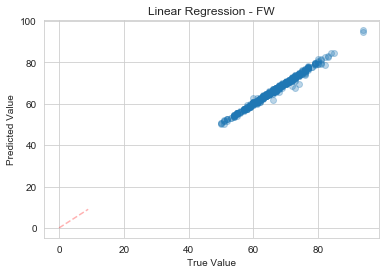


Random Forest Regression - FW
MAE 0.38859550561797773
RMSE 0.5906419094244323


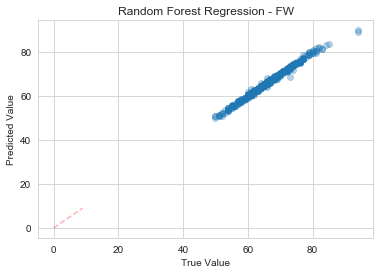


Decision Tree Regression - FW
MAE 0.41385767790262173
RMSE 0.8708771246807064


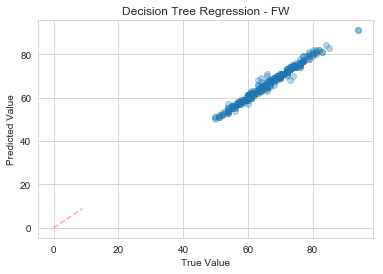


KNN Regression - FW
MAE 0.21802119528962077
RMSE 0.27531628689032733


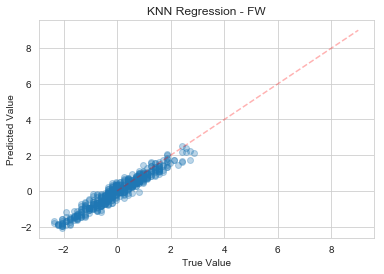


Linear Regression - Attacking Midfield
MAE 0.6705387384315193
RMSE 0.8566150205662847


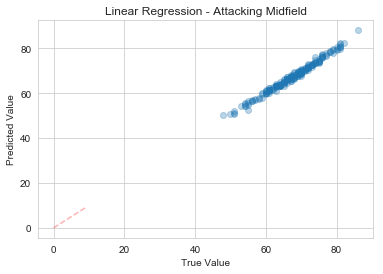


Random Forest Regression - Attacking Midfield
MAE 0.5022000000000001
RMSE 0.7084165441320526


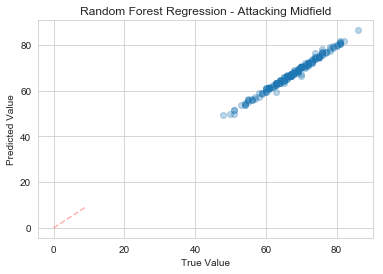


Decision Tree Regression - AM
MAE 0.59
RMSE 0.9486832980505138


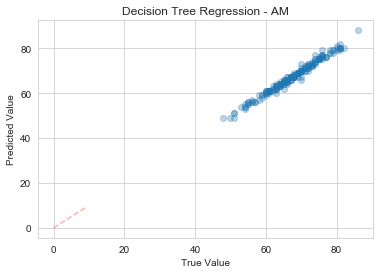


KNN Regression - AM
MAE 0.20811572051133187
RMSE 0.2665266998038533


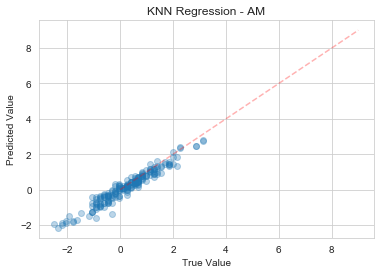


Linear Regression - Wings
MAE 0.576765616530483
RMSE 0.8520619031616734


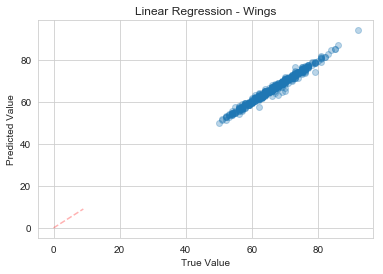


Random Forest Regression - Wings
MAE 0.43865319865319896
RMSE 0.6697615033580773


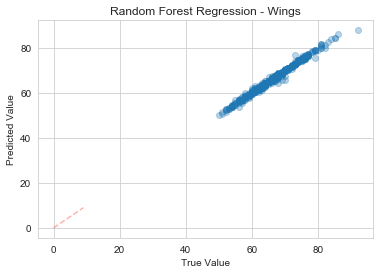


Decision Tree Regression - Wings
MAE 0.569023569023569
RMSE 0.9830208371799483


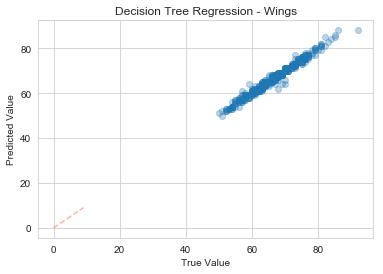


KNN Regression - Wings
MAE 0.214746568641002
RMSE 0.26763005621020886


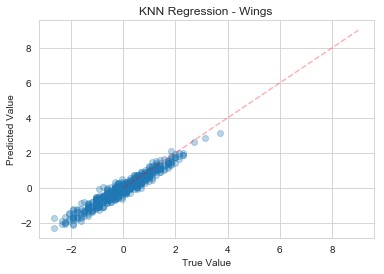


Linear Regression - Central Midfield
MAE 0.7394743658015878
RMSE 1.0512263471910737


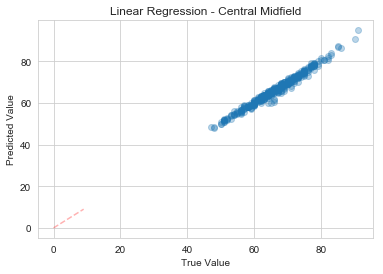


Random Forest Regression - Central Midfield
MAE 0.5118119266055047
RMSE 0.7484110078675004


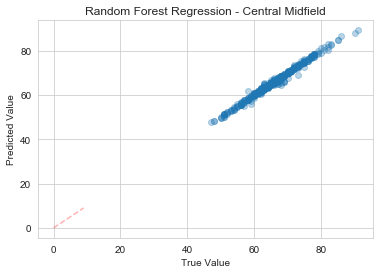


Decision Tree Regression - CM
MAE 0.591743119266055
RMSE 1.1004586199907413


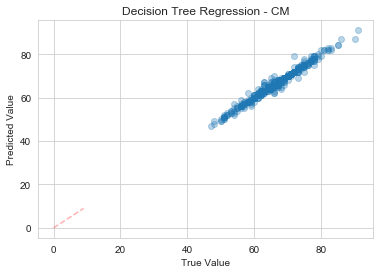


KNN Regression - CM
MAE 0.2110334352176737
RMSE 0.2699406558034612


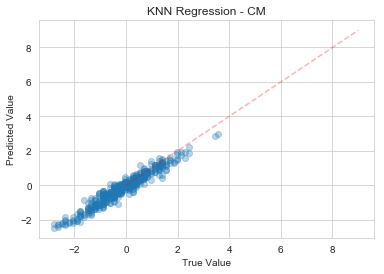


Linear Regression - Defensive Midfield
MAE 0.7928346660402086
RMSE 1.1469785250432643


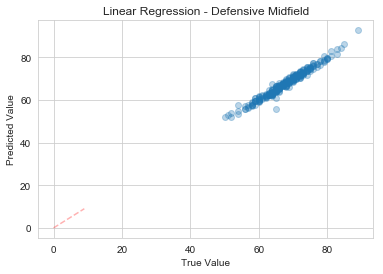


Random Forest Regression - Defensive Midfield
MAE 0.44944444444444426
RMSE 0.6553990514691536


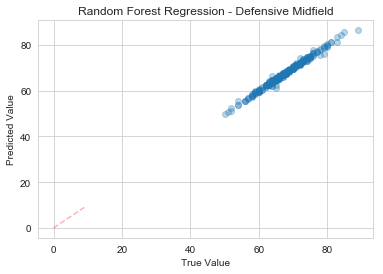


Decision Tree Regression - DM
MAE 0.5972222222222222
RMSE 1.044163673845139


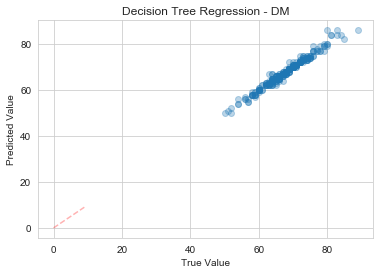


KNN Regression - DM
MAE 0.21593351821257217
RMSE 0.28181312403971637


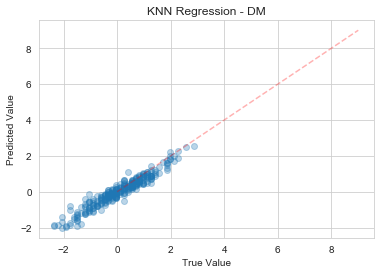


Linear Regression - Fullback
MAE 0.5060933931268377
RMSE 0.8082948125482169


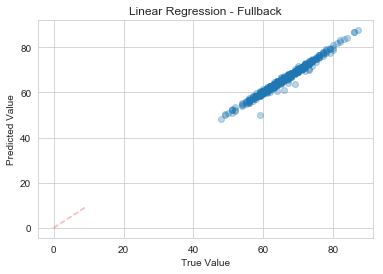


Random Forest Regression - Fullback
MAE 0.3988309352517986
RMSE 0.5923236464621968


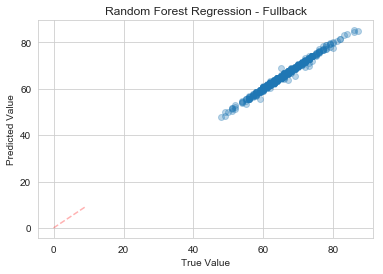


Decision Tree Regression - Fullback
MAE 0.4064748201438849
RMSE 0.961488653939648


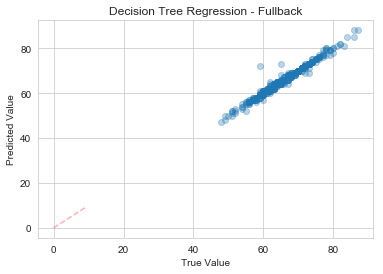


KNN Regression - Fullback
MAE 0.21886272846130486
RMSE 0.2823931391064232


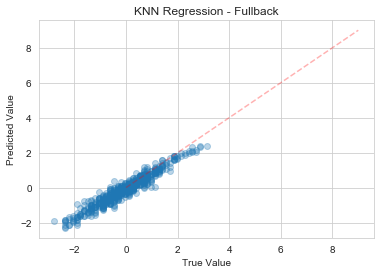


Linear Regression - Centre Back
MAE 0.2906692042633361
RMSE 0.44273173796993215


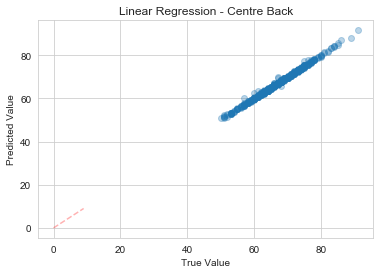


Random Forest Regression - Centre Back
MAE 0.3673948220064729
RMSE 0.5115546771384907


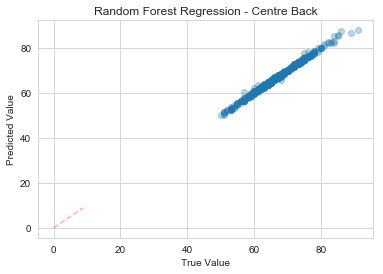


Decision Tree Regression - CB
MAE 0.3155339805825243
RMSE 0.6523544611958066


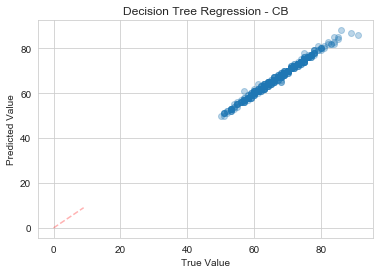


KNN Regression - CB
MAE 0.22157148435529106
RMSE 0.2833061001990832


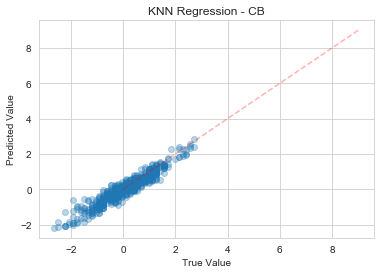


Linear Regression - Goalkeeper
MAE 0.27069446324872
RMSE 0.31399783953019417


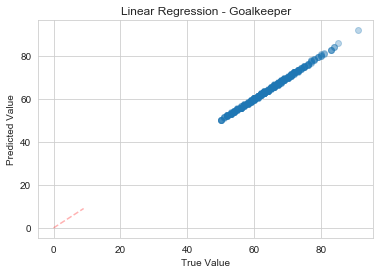


Random Forest Regression - Goalkeeper
MAE 0.4689382716049383
RMSE 0.6209375627147414


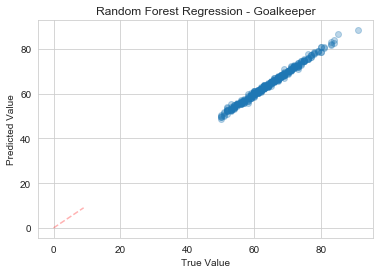


Decision Tree Regression - GK
MAE 1.002469135802469
RMSE 1.4350119369744836


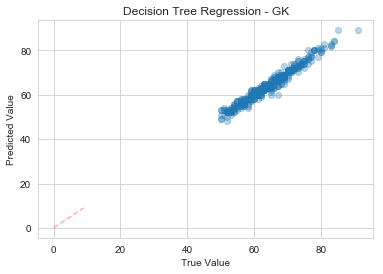


KNN Regression - GK
MAE 0.2535405443818935
RMSE 0.31103456603344165


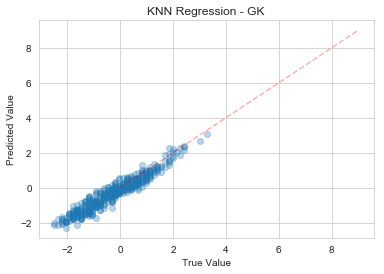

In [13]:
# FW
X_fw_train, X_fw_test, y_fw_train, y_fw_test = train_test_split(X_fw, y_fw, test_size=1.0-threshold, shuffle=True)
X_fwnorm_train, X_fwnorm_test, y_fwnorm_train, y_fwnorm_test = train_test_split(X_fw_norm, y_fw_norm, test_size=1.0-threshold, shuffle=True)

fw_LinReg_model, fw_LinReg_pred = run_experiment('Linear Regression - FW', LinearRegression(), X_fw_train, y_fw_train, X_fw_test, y_fw_test)
fw_RF_model, fw_RF_pred = run_experiment('Random Forest Regression - FW', RandomForestRegressor(100), X_fw_train, y_fw_train.values.ravel(), X_fw_test, y_fw_test)

# fw_LinNorm_model, fw_LinNorm_pred = run_experiment('Linear Regression Normalized - FW', LinearRegression(), X_fwnorm_train, y_fwnorm_train, X_fwnorm_test, y_fwnorm_test)
fw_DT_model, fw_DT_pred = run_experiment('Decision Tree Regression - FW', DecisionTreeRegressor(), X_fw_train, y_fw_train, X_fw_test, y_fw_test)
fw_KNN_model, fw_KNN_pred = run_experiment('KNN Regression - FW', KNeighborsRegressor(), X_fwnorm_train, y_fwnorm_train, X_fwnorm_test, y_fwnorm_test)

# Attacking Midfield
X_am_train, X_am_test, y_am_train, y_am_test = train_test_split(X_am, y_am, test_size=1.0-threshold, shuffle=True)
X_amnorm_train, X_amnorm_test, y_amnorm_train, y_amnorm_test = train_test_split(X_am_norm, y_am_norm, test_size=1.0-threshold, shuffle=True)

am_LinReg_model, am_LinReg_pred = run_experiment('Linear Regression - Attacking Midfield', LinearRegression(), X_am_train, y_am_train, X_am_test, y_am_test)
am_RF_model, am_RF_pred = run_experiment('Random Forest Regression - Attacking Midfield', RandomForestRegressor(100), X_am_train, y_am_train.values.ravel(), X_am_test, y_am_test)

# am_LinNorm_model, am_LinNorm_pred = run_experiment('Linear Regression Normalized - AM', LinearRegression(), X_amnorm_train, y_amnorm_train, X_amnorm_test, y_amnorm_test)
am_DT_model, am_DT_pred = run_experiment('Decision Tree Regression - AM', DecisionTreeRegressor(), X_am_train, y_am_train, X_am_test, y_am_test)
am_KNN_model, am_KNN_pred = run_experiment('KNN Regression - AM', KNeighborsRegressor(), X_amnorm_train, y_amnorm_train, X_amnorm_test, y_amnorm_test)

# Wings
X_wings_train, X_wings_test, y_wings_train, y_wings_test = train_test_split(X_wings, y_wings, test_size=1.0-threshold, shuffle=True)
X_wingsnorm_train, X_wingsnorm_test, y_wingsnorm_train, y_wingsnorm_test = train_test_split(X_wings_norm, y_wings_norm, test_size=1.0-threshold, shuffle=True)

wings_LinReg_model, wings_LinReg_pred = run_experiment('Linear Regression - Wings', LinearRegression(), X_wings_train, y_wings_train, X_wings_test, y_wings_test)
wings_RF_model, wings_RF_pred = run_experiment('Random Forest Regression - Wings', RandomForestRegressor(100), X_wings_train, y_wings_train.values.ravel(), X_wings_test, y_wings_test)

# wings_LinNorm_model, wings_LinNorm_pred = run_experiment('Linear Regression Normalized - Wings', LinearRegression(), X_wingsnorm_train, y_wingsnorm_train, X_wingsnorm_test, y_wingsnorm_test)
wings_DT_model, wings_DT_pred = run_experiment('Decision Tree Regression - Wings', DecisionTreeRegressor(), X_wings_train, y_wings_train, X_wings_test, y_wings_test)
wings_KNN_model, wings_KNN_pred = run_experiment('KNN Regression - Wings', KNeighborsRegressor(), X_wingsnorm_train, y_wingsnorm_train, X_wingsnorm_test, y_wingsnorm_test)

# Central Midfield
X_cm_train, X_cm_test, y_cm_train, y_cm_test = train_test_split(X_cm, y_cm, test_size=1.0-threshold, shuffle=True)
X_cmnorm_train, X_cmnorm_test, y_cmnorm_train, y_cmnorm_test = train_test_split(X_cm_norm, y_cm_norm, test_size=1.0-threshold, shuffle=True)

cm_LinReg_model, cm_LinReg_pred = run_experiment('Linear Regression - Central Midfield', LinearRegression(), X_cm_train, y_cm_train, X_cm_test, y_cm_test)
cm_RF_model, cm_RF_pred = run_experiment('Random Forest Regression - Central Midfield', RandomForestRegressor(100), X_cm_train, y_cm_train.values.ravel(), X_cm_test, y_cm_test)

# cm_LinNorm_model, cm_LinNorm_pred = run_experiment('Linear Regression Normalized - CM', LinearRegression(), X_cmnorm_train, y_cmnorm_train, X_cmnorm_test, y_cmnorm_test)
cm_DT_model, cm_DT_pred = run_experiment('Decision Tree Regression - CM', DecisionTreeRegressor(), X_cm_train, y_cm_train, X_cm_test, y_cm_test)
cm_KNN_model, cm_KNN_pred = run_experiment('KNN Regression - CM', KNeighborsRegressor(), X_cmnorm_train, y_cmnorm_train, X_cmnorm_test, y_cmnorm_test)

# Defensive Midfield
X_dm_train, X_dm_test, y_dm_train, y_dm_test = train_test_split(X_dm, y_dm, test_size=1.0-threshold, shuffle=True)
X_dmnorm_train, X_dmnorm_test, y_dmnorm_train, y_dmnorm_test = train_test_split(X_dm_norm, y_dm_norm, test_size=1.0-threshold, shuffle=True)

dm_LinReg_model, dm_LinReg_pred = run_experiment('Linear Regression - Defensive Midfield', LinearRegression(), X_dm_train, y_dm_train, X_dm_test, y_dm_test)
dm_RF_model, dm_RF_pred = run_experiment('Random Forest Regression - Defensive Midfield', RandomForestRegressor(100), X_dm_train, y_dm_train.values.ravel(), X_dm_test, y_dm_test)

# dm_LinNorm_model, dm_LinNorm_pred = run_experiment('Linear Regression Normalized - DM', LinearRegression(), X_dmnorm_train, y_dmnorm_train, X_dmnorm_test, y_dmnorm_test)
dm_DT_model, dm_DT_pred = run_experiment('Decision Tree Regression - DM', DecisionTreeRegressor(), X_dm_train, y_dm_train, X_dm_test, y_dm_test)
dm_KNN_model, dm_KNN_pred = run_experiment('KNN Regression - DM', KNeighborsRegressor(), X_dmnorm_train, y_dmnorm_train, X_dmnorm_test, y_dmnorm_test)

# Fullback
X_fullback_train, X_fullback_test, y_fullback_train, y_fullback_test = train_test_split(X_fullback, y_fullback, test_size=1.0-threshold, shuffle=True)
X_fullbacknorm_train, X_fullbacknorm_test, y_fullbacknorm_train, y_fullbacknorm_test = train_test_split(X_fullback_norm, y_fullback_norm, test_size=1.0-threshold, shuffle=True)

fullback_LinReg_model, fullback_LinReg_pred = run_experiment('Linear Regression - Fullback', LinearRegression(), X_fullback_train, y_fullback_train, X_fullback_test, y_fullback_test)
fullback_RF_model, fullback_RF_pred = run_experiment('Random Forest Regression - Fullback', RandomForestRegressor(100), X_fullback_train, y_fullback_train.values.ravel(), X_fullback_test, y_fullback_test)

# fullback_LinNorm_model, fullback_LinNorm_pred = run_experiment('Linear Regression Normalized - Fullback', LinearRegression(), X_fullbacknorm_train, y_fullbacknorm_train, X_fullbacknorm_test, y_fullbacknorm_test)
fullback_DT_model, fullback_DT_pred = run_experiment('Decision Tree Regression - Fullback', DecisionTreeRegressor(), X_fullback_train, y_fullback_train, X_fullback_test, y_fullback_test)
fullback_KNN_model, fullback_KNN_pred = run_experiment('KNN Regression - Fullback', KNeighborsRegressor(), X_fullbacknorm_train, y_fullbacknorm_train, X_fullbacknorm_test, y_fullbacknorm_test)

# Centre Back
X_cb_train, X_cb_test, y_cb_train, y_cb_test = train_test_split(X_cb, y_cb, test_size=1.0-threshold, shuffle=True)
X_cbnorm_train, X_cbnorm_test, y_cbnorm_train, y_cbnorm_test = train_test_split(X_cb_norm, y_cb_norm, test_size=1.0-threshold, shuffle=True)

cb_LinReg_model, cb_LinReg_pred = run_experiment('Linear Regression - Centre Back', LinearRegression(), X_cb_train, y_cb_train, X_cb_test, y_cb_test)
cb_RF_model, cb_RF_pred = run_experiment('Random Forest Regression - Centre Back', RandomForestRegressor(100), X_cb_train, y_cb_train.values.ravel(), X_cb_test, y_cb_test)

# cb_LinNorm_model, cb_LinNorm_pred = run_experiment('Linear Regression Normalized - CB', LinearRegression(), X_cbnorm_train, y_cbnorm_train, X_cbnorm_test, y_cbnorm_test)
cb_DT_model, cb_DT_pred = run_experiment('Decision Tree Regression - CB', DecisionTreeRegressor(), X_cb_train, y_cb_train, X_cb_test, y_cb_test)
cb_KNN_model, cb_KNN_pred = run_experiment('KNN Regression - CB', KNeighborsRegressor(), X_cbnorm_train, y_cbnorm_train, X_cbnorm_test, y_cbnorm_test)

# GK
X_gk_train, X_gk_test, y_gk_train, y_gk_test = train_test_split(X_gk, y_gk, test_size=1.0-threshold, shuffle=True)
X_gknorm_train, X_gknorm_test, y_gknorm_train, y_gknorm_test = train_test_split(X_gk_norm, y_gk_norm, test_size=1.0-threshold, shuffle=True)

gk_LinReg_model, gk_LinReg_pred = run_experiment('Linear Regression - Goalkeeper', LinearRegression(), X_gk_train, y_gk_train, X_gk_test, y_gk_test)
gk_RF_model, gk_RF_pred = run_experiment('Random Forest Regression - Goalkeeper', RandomForestRegressor(100), X_gk_train, y_gk_train.values.ravel(), X_gk_test, y_gk_test)

# gk_LinNorm_model, gk_LinNorm_pred = run_experiment('Linear Regression Normalized - GK', LinearRegression(), X_gknorm_train, y_gknorm_train, X_gknorm_test, y_gknorm_test)
gk_DT_model, gk_DT_pred = run_experiment('Decision Tree Regression - GK', DecisionTreeRegressor(), X_gk_train, y_gk_train, X_gk_test, y_gk_test)
gk_KNN_model, gk_KNN_pred = run_experiment('KNN Regression - GK', KNeighborsRegressor(), X_gknorm_train, y_gknorm_train, X_gknorm_test, y_gknorm_test)

## Feature Importance and Error Analysis

In [14]:
# all players feature importance
all_fi = []
for i, col in enumerate(X_all_test.columns):
    all_fi.append([col, all_RF_model.feature_importances_[i]])
pd.DataFrame(all_fi).sort_values(1, ascending=False).head(30)

,0,1
32,Value,0.853780
62,Age,0.079936
38,Potential,0.042483
83,Reactions,0.010674
74,Wage,0.004110
78,Finishing,0.000624
54,International Reputation,0.000331
34,GKPositioning,0.000292
46,GKReflexes,0.000280
55,Special,0.000248


In [15]:
# all players error analysis
y_all_test.columns = ['True Value']
y_all_test['Predicted Value'] = all_RF_pred

df_all_error = pd.concat([X_all_test, y_all_test], axis=1)
df_all_error['abs_error'] = abs(df_all_error['Predicted Value'] - df_all_error['True Value'])
df_all_error.corr()['abs_error'].dropna().sort_values(ascending = False).head(30)

G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


abs_error                   1.000000
Pos_GK                      0.151286
GKPositioning               0.142536
GKDiving                    0.142111
GKReflexes                  0.141705
GKHandling                  0.139485
GKKicking                   0.135046
Value                       0.080317
Wage                        0.078438
AWR_Medium                  0.075790
International Reputation    0.065682
DWR_Medium                  0.062935
Height                      0.061609
Weight                      0.027310
Pos_CM                      0.019990
Foot_Right                  0.009594
Pos_FB                      0.007097
Potential                   0.001916
Pos_CB                     -0.007054
Foot_Left                  -0.009594
AWR_Low                    -0.018708
Pos_DM                     -0.019619
Pos_AM                     -0.035955
Pos_FW                     -0.038734
DWR_High                   -0.039847
DWR_Low                    -0.044159
SlidingTackle              -0.057715
S

In [16]:
# FW feature importance
fw_fi = []
for i, col in enumerate(X_fw_test.columns):
    fw_fi.append([col, fw_RF_model.feature_importances_[i]])
pd.DataFrame(fw_fi).sort_values(1, ascending=False).head(30)

,0,1
64,RS,0.362885
45,LS,0.312623
57,ST,0.282497
32,Value,0.018860
84,RF,0.004814
22,CF,0.004232
71,LF,0.003136
38,Potential,0.001402
6,LM,0.000700
52,RM,0.000579


In [17]:
# FW error analysis
y_fw_test.columns = ['True Value']
y_fw_test['Predicted Value'] = fw_RF_pred

df_fw_error = pd.concat([X_fw_test, y_fw_test], axis=1)
df_fw_error['abs_error'] = abs(df_fw_error['Predicted Value'] - df_fw_error['True Value'])
df_fw_error.corr()['abs_error'].dropna().sort_values(ascending = False).head(30)

G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


abs_error                   1.000000
Value                       0.514954
Wage                        0.509084
International Reputation    0.325459
Potential                   0.193476
Skill Moves                 0.160431
Vision                      0.158329
Dribbling                   0.130432
RAM                         0.128215
LAM                         0.128215
CAM                         0.128215
LW                          0.126240
RW                          0.126240
Balance                     0.123963
RM                          0.122968
LM                          0.122968
BallControl                 0.118928
Acceleration                0.114732
LongPassing                 0.108824
Crossing                    0.106814
LCM                         0.106640
CM                          0.106640
RCM                         0.106640
Agility                     0.104921
CF                          0.101736
RF                          0.101736
LF                          0.101736
S

In [18]:
# AM feature importance
am_fi = []
for i, col in enumerate(X_am_test.columns):
    am_fi.append([col, am_RF_model.feature_importances_[i]])
pd.DataFrame(am_fi).sort_values(1, ascending=False).head(30)

,0,1
5,CAM,0.320329
49,LAM,0.318625
21,RAM,0.289677
32,Value,0.021837
6,LM,0.007920
71,LF,0.006914
22,CF,0.005354
59,RW,0.004533
84,RF,0.004528
52,RM,0.003692


In [19]:
# AM error analysis
y_am_test.columns = ['True Value']
y_am_test['Predicted Value'] = am_RF_pred

df_am_error = pd.concat([X_am_test, y_am_test], axis=1)
df_am_error['abs_error'] = abs(df_am_error['Predicted Value'] - df_am_error['True Value'])
df_am_error.corr()['abs_error'].dropna().sort_values(ascending = False).head(30)

G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


abs_error                   1.000000
Strength                    0.118639
Height                      0.115346
HeadingAccuracy             0.112341
Weight                      0.096449
GKPositioning               0.090853
Aggression                  0.087800
DWR_Medium                  0.046998
Age                         0.045995
Foot_Right                  0.041303
AWR_High                    0.038622
RCB                         0.033719
LCB                         0.033719
CB                          0.033719
SlidingTackle               0.033460
GKKicking                   0.032544
Skill Moves                 0.015258
GKHandling                  0.011334
Marking                     0.010993
StandingTackle              0.007666
Volleys                    -0.001379
ShotPower                  -0.004411
Penalties                  -0.005900
Jumping                    -0.008836
International Reputation   -0.012654
Weak Foot                  -0.024460
Positioning                -0.028841
D

In [20]:
# Wings feature importance
wings_fi = []
for i, col in enumerate(X_wings_test.columns):
    wings_fi.append([col, wings_RF_model.feature_importances_[i]])
pd.DataFrame(wings_fi).sort_values(1, ascending=False).head(30)

,0,1
6,LM,0.526181
52,RM,0.418169
32,Value,0.022219
49,LAM,0.006055
21,RAM,0.005187
5,CAM,0.004883
38,Potential,0.001589
59,RW,0.001378
42,LW,0.001295
62,Age,0.001071


In [21]:
# Wings error analysis
y_wings_test.columns = ['True Value']
y_wings_test['Predicted Value'] = wings_RF_pred

df_wings_error = pd.concat([X_wings_test, y_wings_test], axis=1)
df_wings_error['abs_error'] = abs(df_wings_error['Predicted Value'] - df_wings_error['True Value'])
df_wings_error.corr()['abs_error'].dropna().sort_values(ascending = False).head(30)

G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


abs_error                   1.000000
Value                       0.205628
Wage                        0.170097
International Reputation    0.151529
SlidingTackle               0.129157
LCB                         0.118122
RCB                         0.118122
CB                          0.118122
Interceptions               0.112635
StandingTackle              0.111009
HeadingAccuracy             0.105757
Foot_Right                  0.098307
Marking                     0.092938
AWR_Medium                  0.092540
CDM                         0.082923
RDM                         0.082923
LDM                         0.082923
RB                          0.078782
LB                          0.078782
Height                      0.074072
AWR_Low                     0.059782
Potential                   0.056999
RWB                         0.054297
LWB                         0.054297
Aggression                  0.053550
Weight                      0.040019
DWR_Medium                  0.028863
S

In [22]:
# CM feature importance
cm_fi = []
for i, col in enumerate(X_cm_test.columns):
    cm_fi.append([col, cm_RF_model.feature_importances_[i]])
pd.DataFrame(cm_fi).sort_values(1, ascending=False).head(30)

,0,1
31,RCM,0.365177
51,CM,0.287476
12,LCM,0.196125
32,Value,0.130503
62,Age,0.001843
70,CB,0.001578
80,RCB,0.001515
30,LCB,0.001471
38,Potential,0.001347
73,LDM,0.000675


In [23]:
# CM error analysis
y_cm_test.columns = ['True Value']
y_cm_test['Predicted Value'] = cm_RF_pred

df_cm_error = pd.concat([X_cm_test, y_cm_test], axis=1)
df_cm_error['abs_error'] = abs(df_cm_error['Predicted Value'] - df_cm_error['True Value'])
df_cm_error.corr()['abs_error'].dropna().sort_values(ascending = False).head(30)

G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


abs_error                   1.000000
Stamina                     0.162943
Age                         0.131968
Wage                        0.116690
GKDiving                    0.102180
Aggression                  0.100545
Acceleration                0.097597
SprintSpeed                 0.097161
Marking                     0.094724
GKReflexes                  0.086647
DWR_High                    0.086408
Strength                    0.083391
Value                       0.080642
Jumping                     0.078349
RCB                         0.062557
LCB                         0.062557
CB                          0.062557
Foot_Right                  0.058962
RB                          0.052459
LB                          0.052459
RWB                         0.049177
LWB                         0.049177
HeadingAccuracy             0.047530
International Reputation    0.044641
Weight                      0.043822
Height                      0.040012
StandingTackle              0.038572
C

In [24]:
# DM feature importance
dm_fi = []
for i, col in enumerate(X_dm_test.columns):
    dm_fi.append([col, dm_RF_model.feature_importances_[i]])
pd.DataFrame(dm_fi).sort_values(1, ascending=False).head(30)

,0,1
73,LDM,0.312203
65,CDM,0.301418
60,RDM,0.250126
32,Value,0.063306
55,Special,0.009791
31,RCM,0.009610
12,LCM,0.009395
51,CM,0.008936
38,Potential,0.002642
6,LM,0.002006


In [25]:
# DM error analysis
y_dm_test.columns = ['True Value']
y_dm_test['Predicted Value'] = dm_RF_pred

df_dm_error = pd.concat([X_dm_test, y_dm_test], axis=1)
df_dm_error['abs_error'] = abs(df_dm_error['Predicted Value'] - df_dm_error['True Value'])
df_dm_error.corr()['abs_error'].dropna().sort_values(ascending = False).head(30)

G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


abs_error                   1.000000
Value                       0.262669
SprintSpeed                 0.230883
Acceleration                0.225124
Balance                     0.206740
AWR_High                    0.206670
RW                          0.203715
LW                          0.203715
Agility                     0.203644
LM                          0.199087
RM                          0.199087
Skill Moves                 0.197067
Wage                        0.191365
CAM                         0.190618
LAM                         0.190618
RAM                         0.190618
Dribbling                   0.187549
LF                          0.185349
CF                          0.185349
RF                          0.185349
Finishing                   0.182798
DWR_Low                     0.178033
BallControl                 0.176969
International Reputation    0.174458
Volleys                     0.154168
ST                          0.154133
LS                          0.154133
R

In [26]:
# Fullback feature importance
fullback_fi = []
for i, col in enumerate(X_fullback_test.columns):
    fullback_fi.append([col, fullback_RF_model.feature_importances_[i]])
pd.DataFrame(fullback_fi).sort_values(1, ascending=False).head(30)

,0,1
48,RB,0.457495
7,LB,0.456143
69,RWB,0.030159
77,LWB,0.025138
32,Value,0.014844
60,RDM,0.001513
38,Potential,0.001458
65,CDM,0.000692
80,RCB,0.000658
62,Age,0.000648


In [27]:
# Fullback error analysis
y_fullback_test.columns = ['True Value']
y_fullback_test['Predicted Value'] = fullback_RF_pred

df_fullback_error = pd.concat([X_fullback_test, y_fullback_test], axis=1)
df_fullback_error['abs_error'] = abs(df_fullback_error['Predicted Value'] - df_fullback_error['True Value'])
df_fullback_error.corr()['abs_error'].dropna().sort_values(ascending = False).head(30)

G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


abs_error                   1.000000
Value                       0.172496
Height                      0.138579
Weight                      0.130079
Wage                        0.128526
AWR_Low                     0.116974
HeadingAccuracy             0.106267
International Reputation    0.092205
Potential                   0.087840
Strength                    0.068327
AWR_Medium                  0.053744
Finishing                   0.052287
DWR_High                    0.031613
Foot_Left                   0.028353
GKHandling                  0.021801
Weak Foot                   0.016913
LS                         -0.012505
ST                         -0.012505
RS                         -0.012505
ShortPassing               -0.017700
DWR_Low                    -0.019085
True Value                 -0.019817
GKDiving                   -0.020864
Penalties                  -0.023235
DWR_Medium                 -0.023874
ShotPower                  -0.026190
Foot_Right                 -0.028353
L

In [28]:
# CB feature importance
cb_fi = []
for i, col in enumerate(X_cb_test.columns):
    cb_fi.append([col, cb_RF_model.feature_importances_[i]])
pd.DataFrame(cb_fi).sort_values(1, ascending=False).head(30)

,0,1
70,CB,0.394080
80,RCB,0.302798
30,LCB,0.289217
32,Value,0.003774
38,Potential,0.001378
62,Age,0.000699
21,RAM,0.000332
49,LAM,0.000297
22,CF,0.000269
41,Composure,0.000250


In [29]:
# CB error analysis
y_cb_test.columns = ['True Value']
y_cb_test['Predicted Value'] = cb_RF_pred

df_cb_error = pd.concat([X_cb_test, y_cb_test], axis=1)
df_cb_error['abs_error'] = abs(df_cb_error['Predicted Value'] - df_cb_error['True Value'])
df_cb_error.corr()['abs_error'].dropna().sort_values(ascending = False).head(30)

G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


abs_error                   1.000000
Wage                        0.356345
Value                       0.318164
International Reputation    0.214018
SprintSpeed                 0.167097
Acceleration                0.158589
Skill Moves                 0.152688
Potential                   0.128278
Volleys                     0.102580
Stamina                     0.091532
RWB                         0.085352
LWB                         0.085352
LB                          0.084747
RB                          0.084747
RM                          0.073988
LM                          0.073988
RW                          0.072318
LW                          0.072318
Balance                     0.068966
Dribbling                   0.065946
StandingTackle              0.065801
SlidingTackle               0.064296
AWR_High                    0.060498
RF                          0.060250
LF                          0.060250
CF                          0.060250
Special                     0.058521
S

In [30]:
# GK feature importance
gk_fi = []
for i, col in enumerate(X_gk_test.columns):
    gk_fi.append([col, gk_RF_model.feature_importances_[i]])
pd.DataFrame(gk_fi).sort_values(1, ascending=False).head(30)

,0,1
72,GKDiving,0.382908
34,GKPositioning,0.254674
46,GKReflexes,0.234172
32,Value,0.075324
0,GKHandling,0.021513
83,Reactions,0.008878
38,Potential,0.006808
62,Age,0.003907
55,Special,0.001195
74,Wage,0.001133


In [31]:
# GK error analysis
y_gk_test.columns = ['True Value']
y_gk_test['Predicted Value'] = gk_RF_pred

df_gk_error = pd.concat([X_gk_test, y_gk_test], axis=1)
df_gk_error['abs_error'] = abs(df_gk_error['Predicted Value'] - df_gk_error['True Value'])
df_gk_error.corr()['abs_error'].dropna().sort_values(ascending = False).head(30)

G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


abs_error                   1.000000
Value                       0.255300
Wage                        0.213137
International Reputation    0.197873
Weak Foot                   0.101701
Height                      0.086297
GKHandling                  0.073590
BallControl                 0.066538
Vision                      0.059222
Aggression                  0.056908
LongPassing                 0.056222
Potential                   0.055764
Marking                     0.054874
GKPositioning               0.054553
HeadingAccuracy             0.053536
ShotPower                   0.050345
Age                         0.041494
GKKicking                   0.032260
ShortPassing                0.029706
Dribbling                   0.027875
Weight                      0.026511
Foot_Left                   0.025529
LongShots                   0.025133
True Value                  0.020990
Interceptions               0.018143
Predicted Value             0.018001
Strength                    0.015750
C